# 图像增广

在[“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.ipynb)小节里我们提到过，大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入实验所需的包或模块。

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.0.0


## 常用的图像增广方法

我们来读取一张形状为$400\times 500$（高和宽分别为400像素和500像素）的图像作为实验的样例。

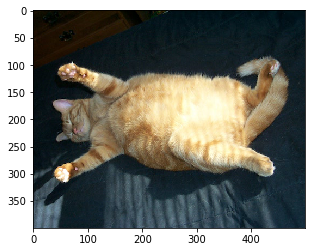

In [2]:
from matplotlib import pyplot as plt

img = plt.imread('../img/cat1.jpg')
plt.imshow(img)

下面定义绘图函数`show_images`。

In [3]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数`apply`。这个函数对输入图像`img`多次运行图像增广方法`aug`并展示所有的结果。

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

### 翻转和裁剪

左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过`tf.image.random_flip_left_right`来实现一半概率的图像左右翻转。

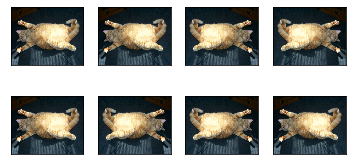

In [5]:
apply(img, tf.image.random_flip_left_right)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建`tf.image.random_flip_up_down`实例来实现一半概率的图像上下翻转。

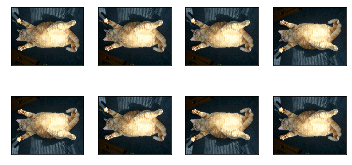

In [6]:
apply(img, tf.image.random_flip_up_down)

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在[“池化层”](../chapter_convolutional-neural-networks/pooling.ipynb)一节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积$10\% \sim 100\%$的区域，且该区域的宽和高之比随机取自$0.5 \sim 2$，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中$a$和$b$之间的随机数指的是从区间$[a,b]$中随机均匀采样所得到的连续值。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186F310AD48>,
      dtype=object)

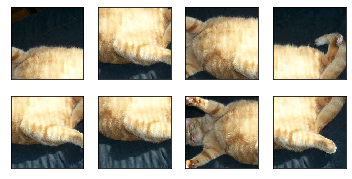

In [7]:
aug=tf.image.random_crop
num_rows=2
num_cols=4
scale=1.5
crop_size=200

Y = [aug(img, (crop_size, crop_size, 3)) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

### 变化颜色

另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将图像的亮度随机变化为原图亮度的$50\%$（即$1-0.5$）$\sim 150\%$（即$1+0.5$）。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186F3086848>,
      dtype=object)

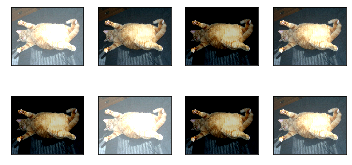

In [8]:
aug=tf.image.random_brightness
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

类似地，我们也可以随机变化图像的色调。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186F3013888>,
      dtype=object)

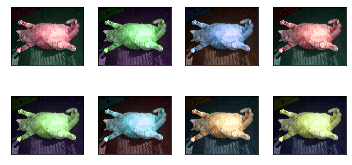

In [9]:
aug=tf.image.random_hue
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

## 使用图像增广训练模型

下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用CIFAR-10数据集，而不是之前我们一直使用的Fashion-MNIST数据集。这是因为Fashion-MNIST数据集中物体的位置和尺寸都已经经过归一化处理，而CIFAR-10数据集中物体的颜色和大小区别更加显著。下面展示了CIFAR-10数据集中前32张训练图像。

In [10]:
(x, y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
print(x.shape, test_x.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


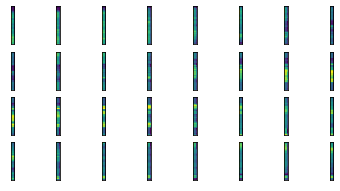

In [11]:
show_images(x[0:32][0], 4, 8, scale=0.8);

我们在CIFAR-10数据集上训练[“残差网络（ResNet）”](../chapter_convolutional-neural-networks/resnet.ipynb)一节介绍的ResNet-18模型。
下面我们定义ResNet模型：

In [12]:
from tensorflow.keras import layers,activations
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_channels,
                                   padding='same',
                                   kernel_size=3,
                                   strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3,padding='same')
        if use_1x1conv:
            self.conv3 = layers.Conv2D(num_channels,
                                       kernel_size=1,
                                       strides=strides)
        else:
            self.conv3 = None
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, X):
        Y = activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return activations.relu(Y + X)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self,num_channels, num_residuals, first_block=False,**kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.listLayers=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.listLayers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.listLayers.append(Residual(num_channels))      
    
    def call(self, X):
        for layer in self.listLayers.layers:
            X = layer(X)
        return X

class ResNet(tf.keras.Model):
    def __init__(self,num_blocks,**kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.conv=tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')
        self.bn=tf.keras.layers.BatchNormalization()
        self.relu=tf.keras.layers.Activation('relu')
        self.mp=tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        self.resnet_block1=ResnetBlock(64,num_blocks[0], first_block=True)
        self.resnet_block2=ResnetBlock(128,num_blocks[1])
        self.resnet_block3=ResnetBlock(256,num_blocks[2])
        self.resnet_block4=ResnetBlock(512,num_blocks[3])
        self.gap=tf.keras.layers.GlobalAvgPool2D()
        self.fc=tf.keras.layers.Dense(units=10,activation=tf.keras.activations.softmax)

    def call(self, x):
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.mp(x)
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.resnet_block4(x)
        x=self.gap(x)
        x=self.fc(x)
        return x

net = ResNet([2,2,2,2])

下面使用随机左右翻转的图像增广来训练模型。

In [15]:
x = [tf.image.random_flip_left_right(i) for i in x]

net.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = net.fit(x, y,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)
test_scores = net.evaluate(test_x, test_y, verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 34s 860us/sample - loss: 1.4808 - accuracy: 0.4748 - val_loss: 2.2286 - val_accuracy: 0.3228
Epoch 2/5
40000/40000 [==============================] - 29s 730us/sample - loss: 1.0926 - accuracy: 0.6130 - val_loss: 1.3995 - val_accuracy: 0.5257
Epoch 3/5
40000/40000 [==============================] - 29s 731us/sample - loss: 0.9209 - accuracy: 0.6765 - val_loss: 1.2786 - val_accuracy: 0.5700
Epoch 4/5
40000/40000 [==============================] - 29s 728us/sample - loss: 0.8061 - accuracy: 0.7167 - val_loss: 1.0461 - val_accuracy: 0.6405
Epoch 5/5
40000/40000 [==============================] - 29s 729us/sample - loss: 0.6999 - accuracy: 0.7553 - val_loss: 0.9424 - val_accuracy: 0.6718
10000/1 - 3s - loss: 1.1749 - accuracy: 0.6674
